### Imports

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

### Dataset Exploration

In [31]:
def explore_bbox_dataset(coco_annotations_file_path):
    with open(coco_annotations_file_path, "r") as f:
        coco_annotations = json.load(f)

    # number of images
    images_info = coco_annotations['images']
    num_images = len(images_info)
    print(f"Dataset contains {num_images} images.")

    # Image sizes
    image_sizes = {(img['height'], img['width']) for img in images_info}
    print(f"Dataset contains images of the following sizes: {list(image_sizes)}")

    # extracting the boundign boxes
    bboxes = np.round(np.array([img['bbox'] for img in coco_annotations['annotations']])).astype(int)

    # width distribution
    widths = bboxes[:, 2]
    print('\nWidth:')
    stats(widths, "Width")

    # height distribution
    heights = bboxes[:, 3]
    print('\nHeight:')
    stats(heights, "Height")

    # Area distribution
    areas = widths * heights
    print("\nArea:")
    stats(areas, "Area")

    # Width to Height Ratio
    aspect_ratios = widths / heights
    print("\nAspect Ratio: ")
    stats(aspect_ratios, "Aspect Ratio")

    # Squareness
    squareness = np.min(bboxes[:, 2:],axis=1)**2 / areas
    print("\nSquareness: ")
    stats(squareness, 'Squareness')

    # Heat map of bbox location
    bbox_to_heat_map(bboxes, 640, 640)

def stats(data, title):
    min = np.min(data)
    max = np.max(data)
    mean = np.mean(data)
    median = np.median(data)
    var = np.var(data)
    sd= np.std(data) 

    print(f'\t- min: {np.round(min, 3)}')
    print(f'\t- max: {np.round(max, 3)}')
    print(f'\t- mean: {np.round(mean, 3)}')
    print(f'\t- median: {np.round(median, 3)}')
    print(f'\t- variance: {np.round(var, 3)}')
    print(f'\t- SD: {np.round(sd, 3)}')

    plt.hist(data, color='b')
    plt.title(title)
    plt.show()

          
def bbox_to_heat_map(bbox_data, width, height):
    num_boxes = bbox_data.shape[0]
    heat_map = np.zeros((num_boxes, width, height))

    for i in range(num_boxes):
        x = bbox_data[i][0]
        y = bbox_data[i][1]
        w = bbox_data[i][2]
        h = bbox_data[i][3]
        heat_map[i, x:x+w, y:y+h] = 1

    heat_map = np.mean(heat_map, axis=0)
    plt.imshow(heat_map, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Bounding Box Location Average')
    plt.show()

    coverage_area = heat_map.copy()
    coverage_area[coverage_area>0] = 1

    plt.imshow(coverage_area, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Bounding Box Coverage')
    plt.show()
     
    return heat_map


## Exploring Training Set

Dataset contains 1502 images.
Dataset contains images of the following sizes: [(640, 640)]

Width:
	- min: 2
	- max: 372
	- mean: 116.49
	- median: 110.0
	- variance: 1969.121
	- SD: 44.375


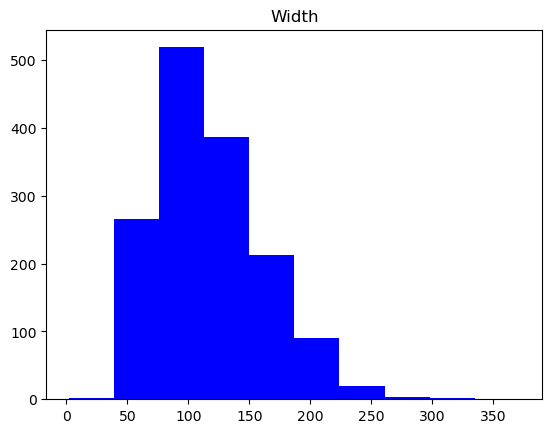


Height:
	- min: 8
	- max: 468
	- mean: 116.022
	- median: 109.0
	- variance: 1756.096
	- SD: 41.906


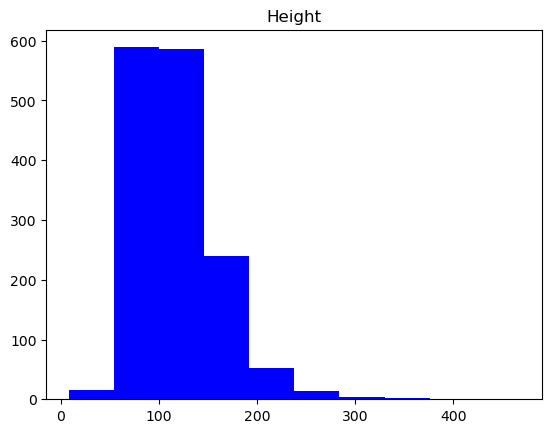


Area:
	- min: 16
	- max: 128700
	- mean: 14964.119
	- median: 12010.5
	- variance: 120548175.492
	- SD: 10979.443


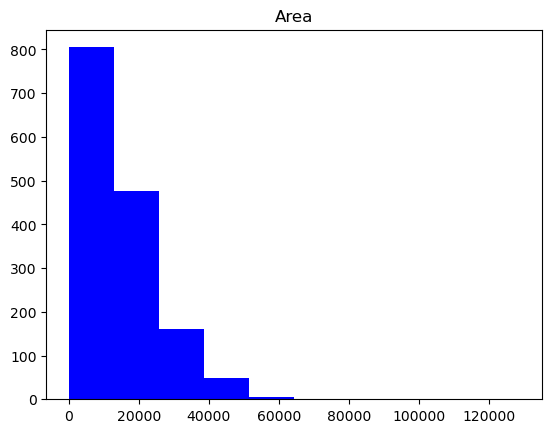


Aspect Ratio: 
	- min: 0.25
	- max: 3.351
	- mean: 1.017
	- median: 1.0
	- variance: 0.055
	- SD: 0.235


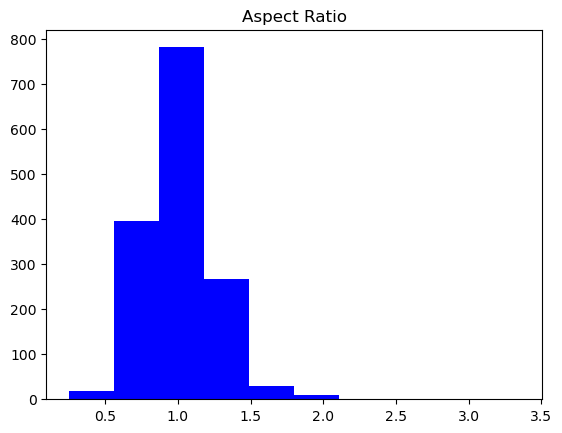


Squareness: 
	- min: 0.25
	- max: 1.0
	- mean: 0.848
	- median: 0.866
	- variance: 0.013
	- SD: 0.112


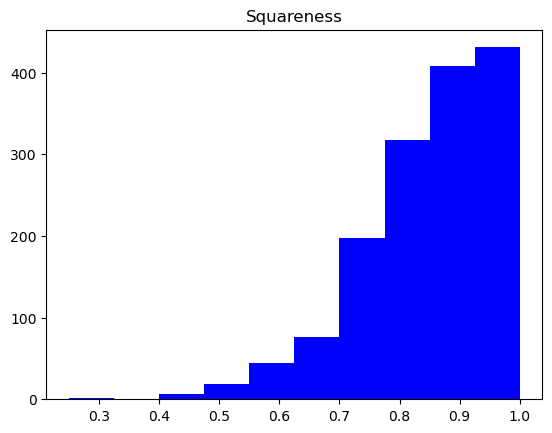

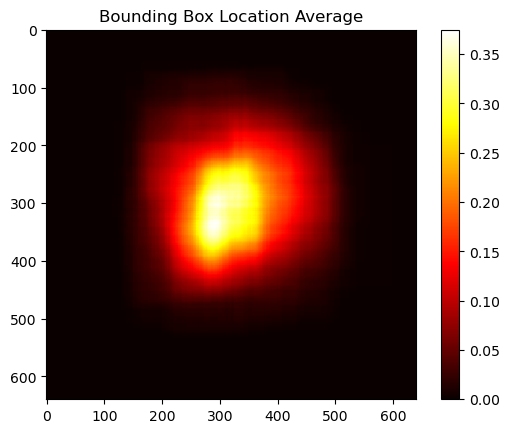

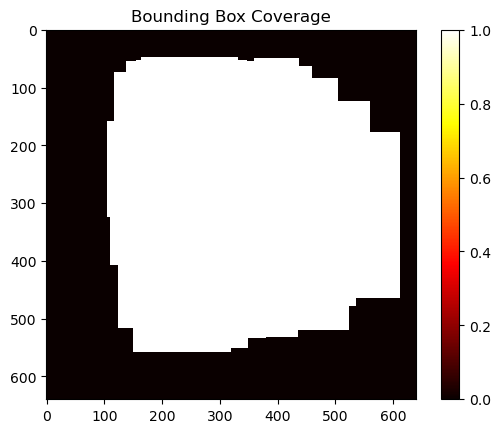

In [32]:
train_coco = explore_bbox_dataset('./../datasets/tumor-segmentation/train/_annotations.coco.json')

## Explorating Validation Set

Dataset contains 1502 images.
Dataset contains images of the following sizes: [(640, 640)]

Width:
	- min: 2
	- max: 372
	- mean: 116.49
	- median: 110.0
	- variance: 1969.121
	- SD: 44.375


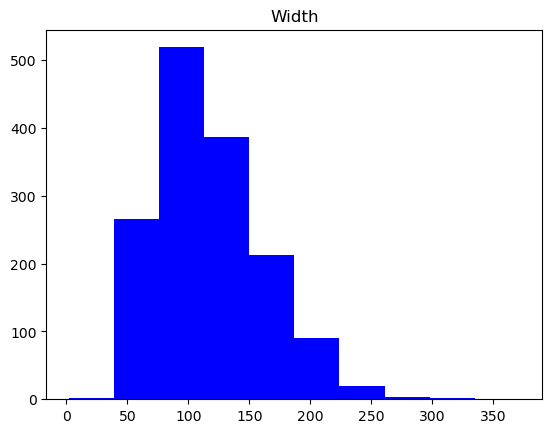


Height:
	- min: 8
	- max: 468
	- mean: 116.022
	- median: 109.0
	- variance: 1756.096
	- SD: 41.906


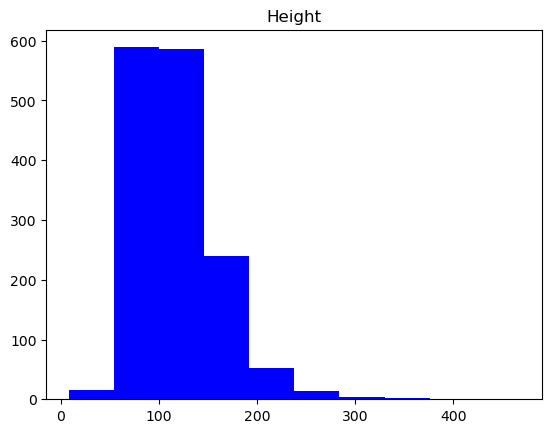


Area:
	- min: 16
	- max: 128700
	- mean: 14964.119
	- median: 12010.5
	- variance: 120548175.492
	- SD: 10979.443


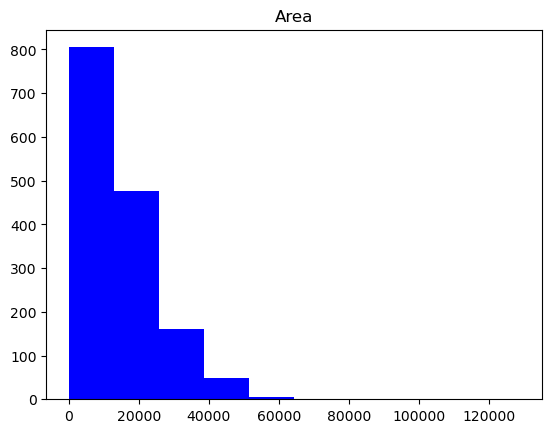


Aspect Ratio: 
	- min: 0.25
	- max: 3.351
	- mean: 1.017
	- median: 1.0
	- variance: 0.055
	- SD: 0.235


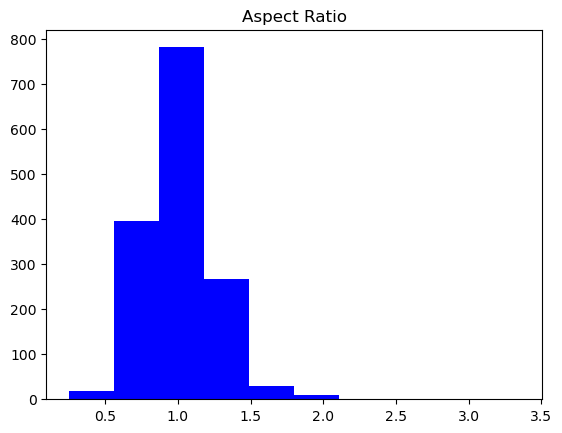


Squareness: 
	- min: 0.25
	- max: 1.0
	- mean: 0.848
	- median: 0.866
	- variance: 0.013
	- SD: 0.112


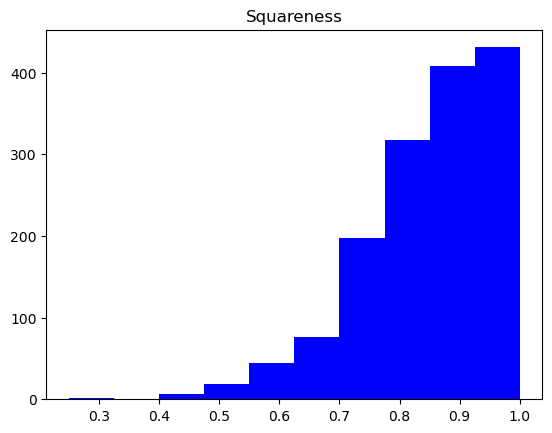

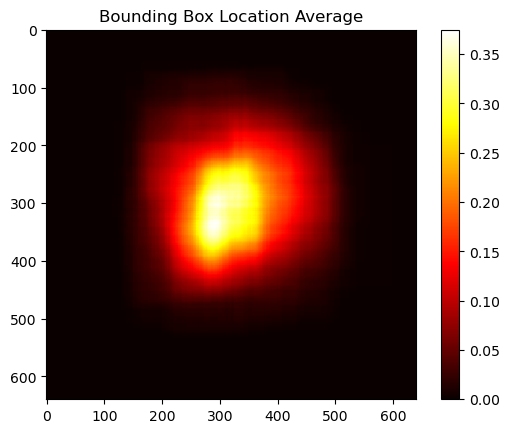

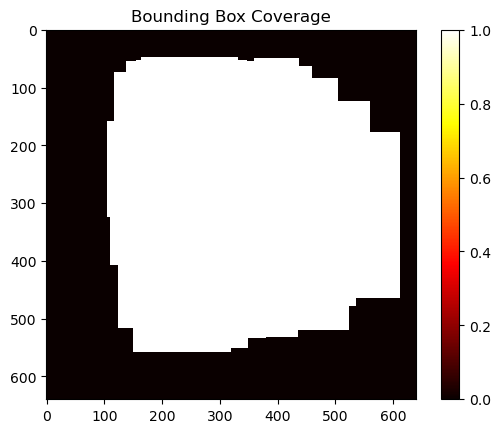

In [33]:
explore_bbox_dataset('./../datasets/tumor-segmentation/train/_annotations.coco.json')

## Exploring Test Set

Dataset contains 215 images.
Dataset contains images of the following sizes: [(640, 640)]

Width:
	- min: 26
	- max: 326
	- mean: 115.405
	- median: 108.0
	- variance: 2540.185
	- SD: 50.4


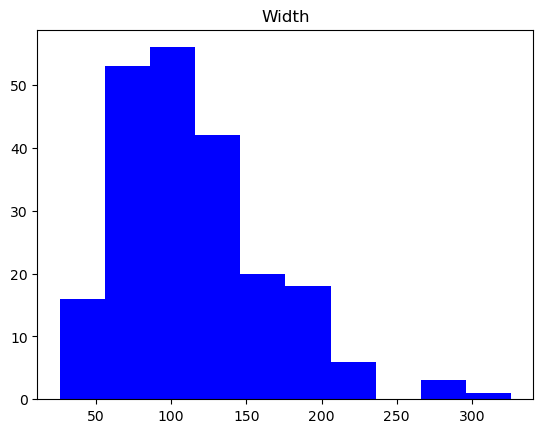


Height:
	- min: 30
	- max: 324
	- mean: 114.367
	- median: 105.0
	- variance: 1957.311
	- SD: 44.242


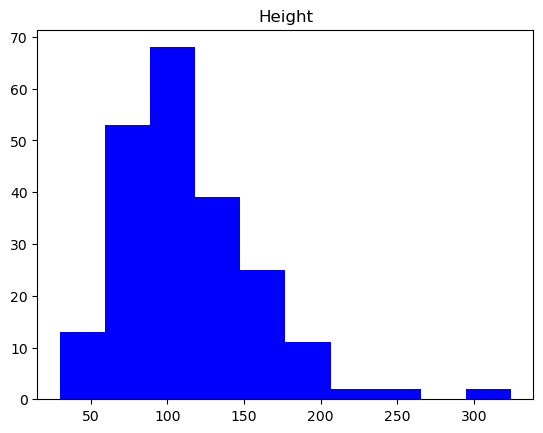


Area:
	- min: 780
	- max: 71280
	- mean: 14970.474
	- median: 11448.0
	- variance: 146377623.821
	- SD: 12098.662


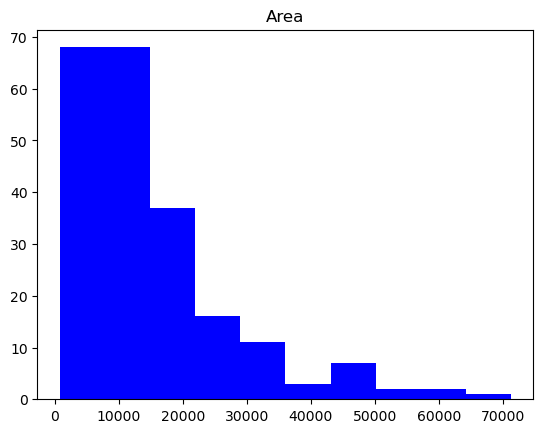


Aspect Ratio: 
	- min: 0.472
	- max: 1.71
	- mean: 1.011
	- median: 0.992
	- variance: 0.052
	- SD: 0.228


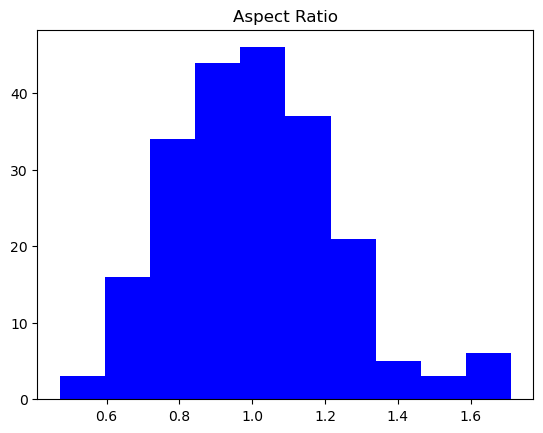


Squareness: 
	- min: 0.472
	- max: 1.0
	- mean: 0.843
	- median: 0.859
	- variance: 0.012
	- SD: 0.108


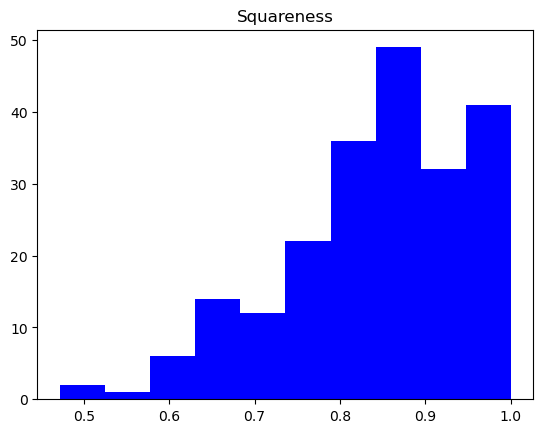

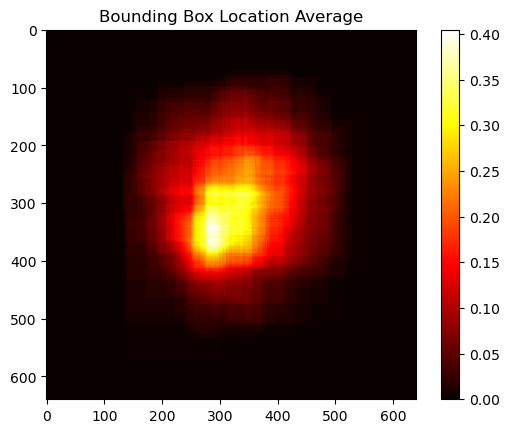

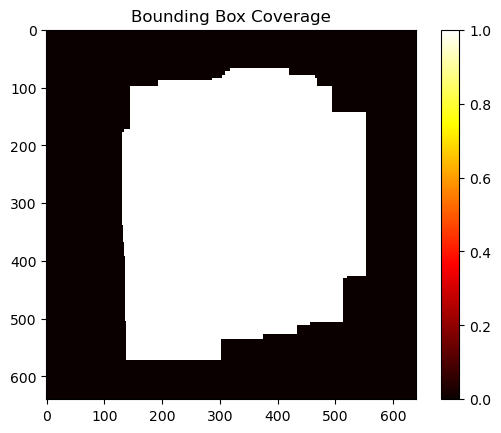

In [34]:
explore_bbox_dataset('./../datasets/tumor-segmentation/test/_annotations.coco.json')

## Generating Anchor Boxes
We need to ensure that all of the bounding boxes can be detected by at least 1 anchor with a sufficient IoU.

In [47]:
import numpy as np

def generate_anchores(image_size, scales, aspect_ratios, feature_map_size):
    anchor_boxes_centers = []  # For center coordinates
    anchor_boxes_corners = []  # For corner coordinates
    
    step_size = image_size / feature_map_size  # Size of one grid cell
    
    for x in range(feature_map_size):
        for y in range(feature_map_size):
            center_x = (x + 0.5) * step_size
            center_y = (y + 0.5) * step_size
            
            for scale in scales:
                for aspect_ratio in aspect_ratios:
                    box_height = image_size * scale / np.sqrt(aspect_ratio)
                    box_width = image_size * scale * np.sqrt(aspect_ratio)
                    
                    # Center coordinates with width and height
                    anchor_boxes_centers.append([center_x, center_y, box_width, box_height])
                    
                    # Convert to corner coordinates
                    x_min = center_x - box_width / 2
                    y_min = center_y - box_height / 2
                    x_max = center_x + box_width / 2
                    y_max = center_y + box_height / 2
                    anchor_boxes_corners.append([x_min, y_min, x_max, y_max])
    
    return np.array(anchor_boxes_centers), np.array(anchor_boxes_corners)


In [ ]:
# Image dimensions
image_size = 640  # Assuming square images

# Scales (relative to the image size)
scales = [0.1, 0.2, 0.3]  # Example scales

# Aspect ratios
aspect_ratios = [0.66667, 1, 1.5]

# Feature map size
feature_map_size = 20  # Assuming a 20x20 grid over the image

# Generate anchored boxes
anchore_centers, anchor_corners = generate_anchores(image_size, scales, aspect_ratios, feature_map_size)

print("Anchored boxes (center_x, center_y, width, height):")
print(anchore_centers)
print(anchor_corners)